In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder

from transformers import GPT2Tokenizer
from transformers import GPT2Config
from transformers import GPT2LMHeadModel
from transformers import AdamW
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Ensure that the NLTK sentence tokenizer is downloaded
nltk.download('punkt')

2024-05-21 18:08:11.564306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 18:08:11.564465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 18:08:11.744449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [4]:
image_path = "/kaggle/input/cxr-dataset/images/"
images = glob(image_path + "*.png")
len(images)

7470

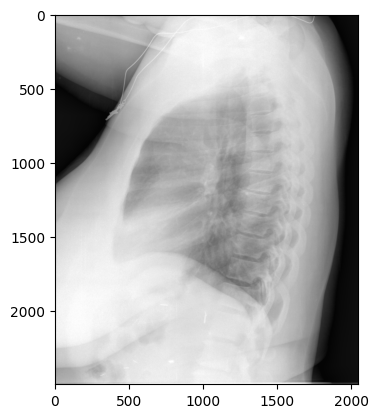

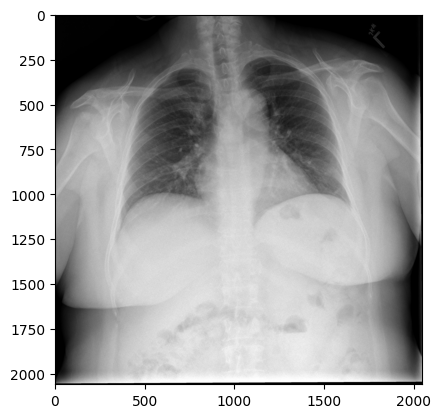

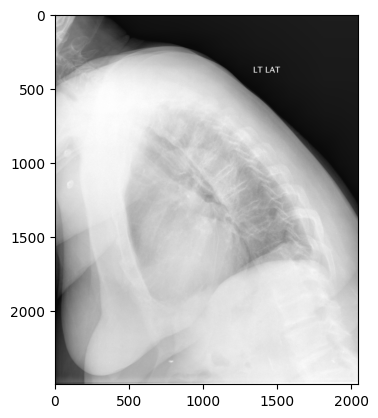

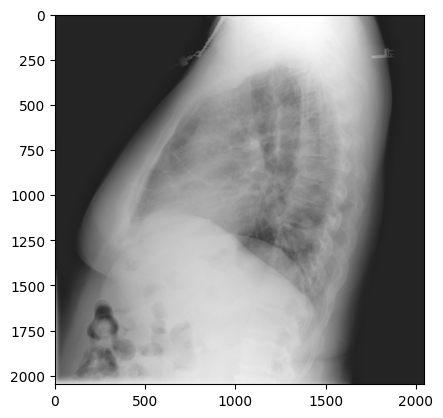

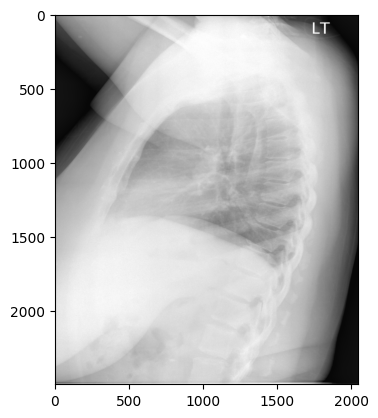

In [7]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [5]:
reports_df = pd.read_csv('/kaggle/input/cxr-dataset/reports.csv')
reports_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [6]:
projections_df = pd.read_csv('/kaggle/input/cxr-dataset/projections.csv')
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [10]:
reports_df.shape

(3851, 8)

In [11]:
projections_df.shape

(7466, 3)

In [12]:
class ImageCaptionData:
    def __init__(self, reports_df, projections_df):
        self.reports_df = reports_df.set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = reports_df[reports_df.findings.notnull()].uid.unique()
        
    def get_sample(self):
        uid = np.random.choice(self.uids)
        images = list(self.projections_df.loc[[uid]]['filename'])
        projections = list(self.projections_df.loc[[uid]]['projection'])
        findings = self.reports_df.loc[uid]['findings']
        impressions = self.reports_df.loc[uid]['impression']
        return uid, images, projections, findings,impressions
    
    def get_num_images_per_report(self):
        # Group by 'uid' and count the number of images
        image_counts = self.projections_df.groupby('uid').size()
        return image_counts

    def plot_image_distribution(self):
        # Get the number of images per report
        image_counts = self.get_num_images_per_report()
        
        # Count the number of reports with each possible number of images
        image_count_distribution = image_counts.value_counts().sort_index()
        
        # Plotting the bar graph
        plt.figure(figsize=(10, 5))
        plt.bar(image_count_distribution.index, image_count_distribution.values, color='skyblue')
        plt.xlabel('Number of Images per Report')
        plt.ylabel('Number of Reports')
        plt.title('Distribution of Number of Images per Report')
        plt.xticks(image_count_distribution.index)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

In [13]:
paired_dataset = ImageCaptionData(reports_df, projections_df)
uid, images, projections, findings,impressions = paired_dataset.get_sample()

# No of Images per Report

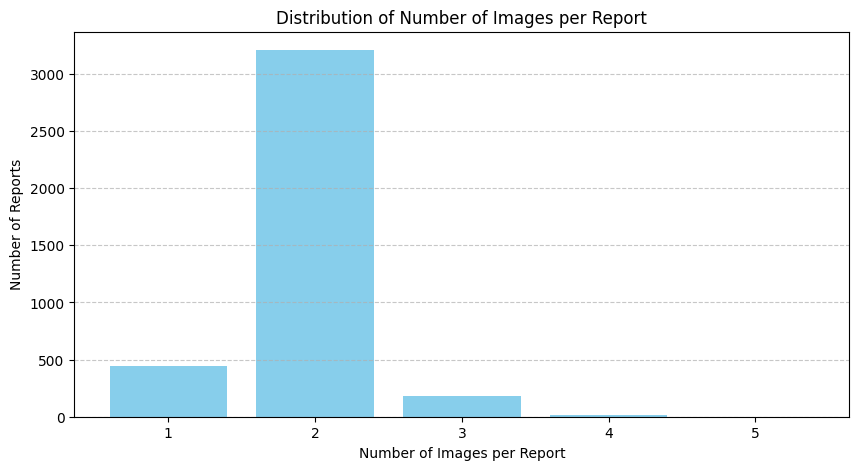

In [14]:
paired_dataset.plot_image_distribution()


# Word Cloud of Findings

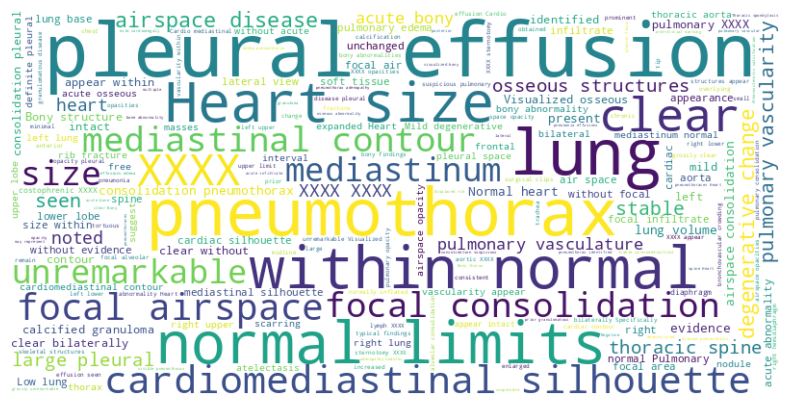

In [15]:
# Combine all findings and impressions into one string, ensuring to handle NaN values
all_findings = " ".join(reports_df['findings'].dropna().astype(str).values)
all_impressions = " ".join(reports_df['impression'].dropna().astype(str).values)
#combined_text = all_findings + " " + all_impressions
#print("hi")
#print(combined_text)
# Generate the word cloud if combined_text is not empty
if all_findings.strip():  # Ensure there is content to generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_findings)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()




# Word Cloud of Impressions

In [ ]:
if all_impressions.strip():  # Ensure there is content to generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_impressions)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Top Frequent Sentences in Findings

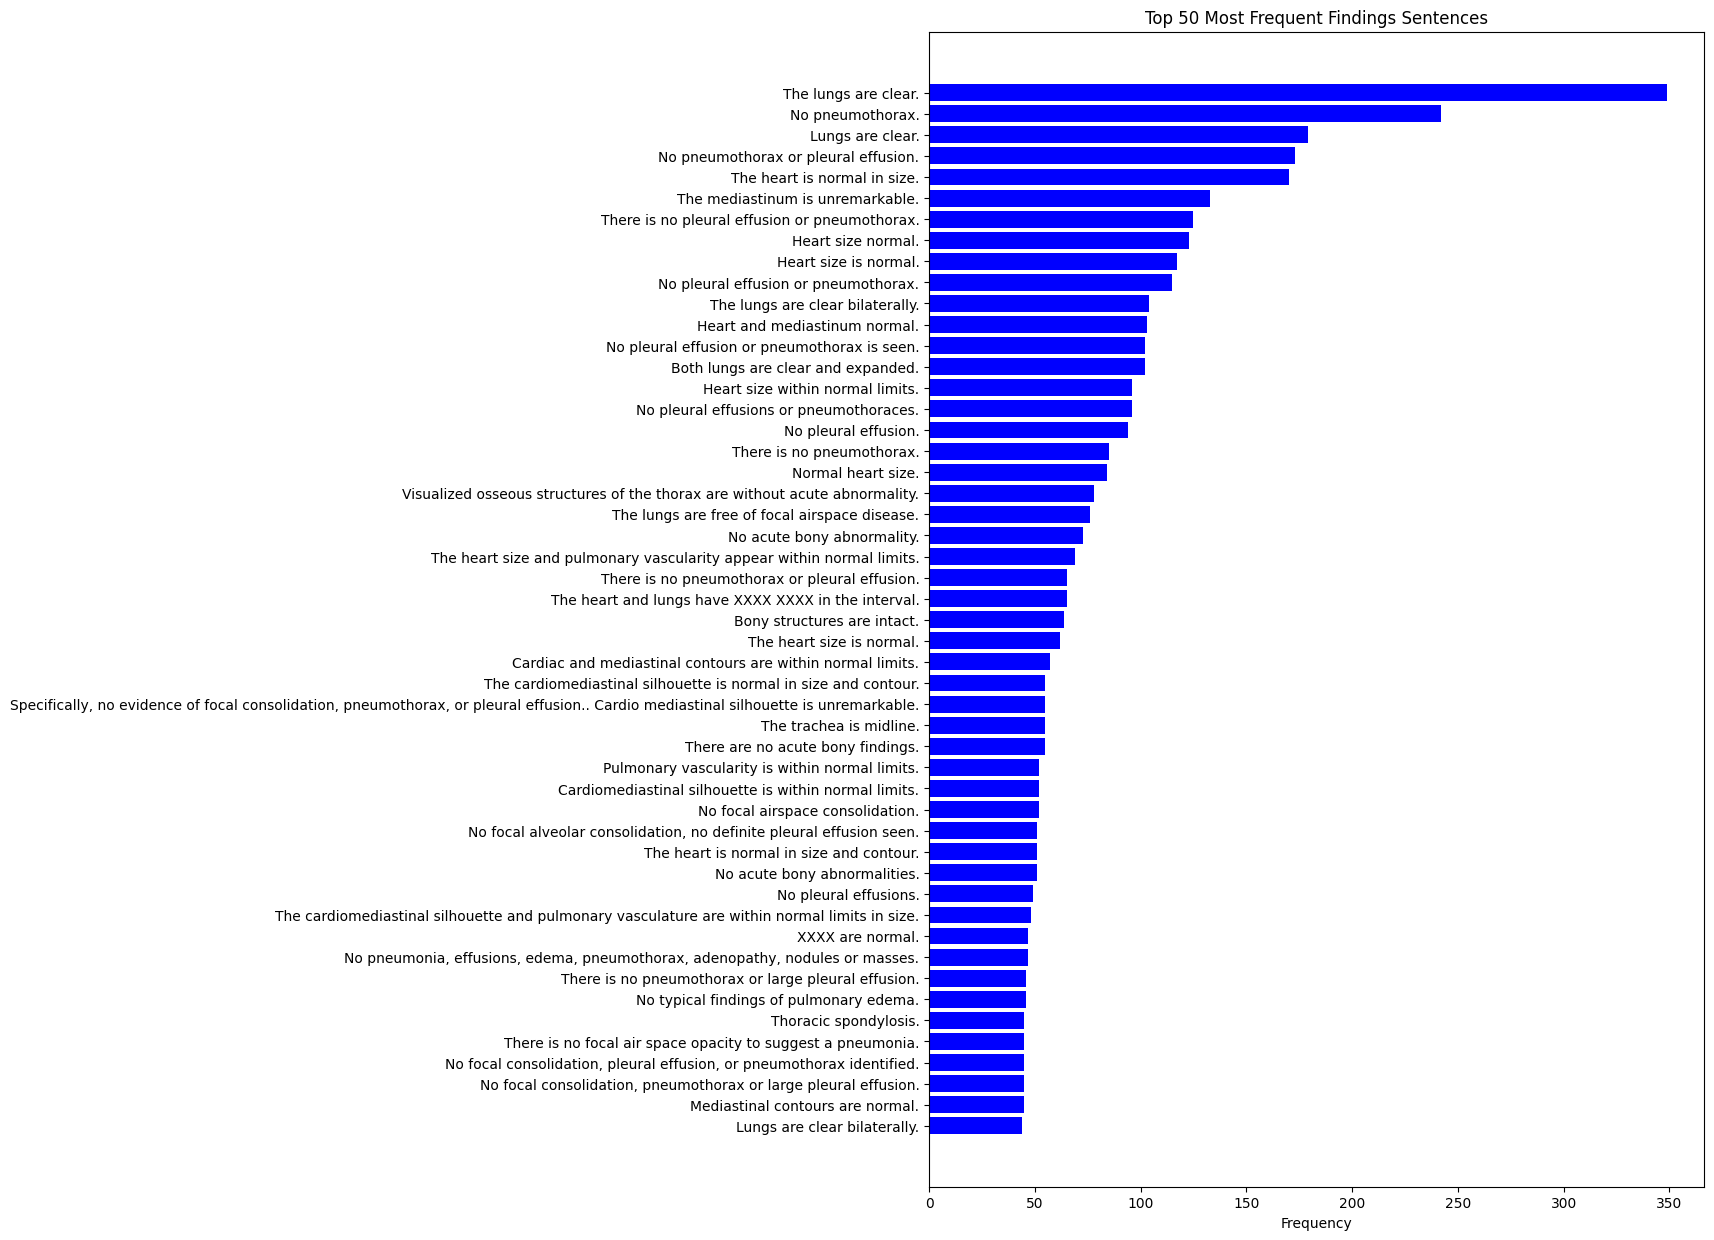

In [17]:
# Tokenize the findings and impressions into sentences
findings_sentences = nltk.sent_tokenize(all_findings)
impressions_sentences = nltk.sent_tokenize(all_impressions)

# Count the frequency of each sentence
findings_counter = Counter(findings_sentences)
impressions_counter = Counter(impressions_sentences)

# Get the top 50 most common sentences
top_50_findings = findings_counter.most_common(50)
top_50_impressions = impressions_counter.most_common(50)

# Plot the top 50 sentences for findings
findings_sentences, findings_frequencies = zip(*top_50_findings)
plt.figure(figsize=(10, 15))
plt.barh(findings_sentences, findings_frequencies, color='blue')
plt.xlabel('Frequency')
plt.title('Top 50 Most Frequent Findings Sentences')
plt.gca().invert_yaxis()
plt.show()



# Top Frequent Sentences in Impressions

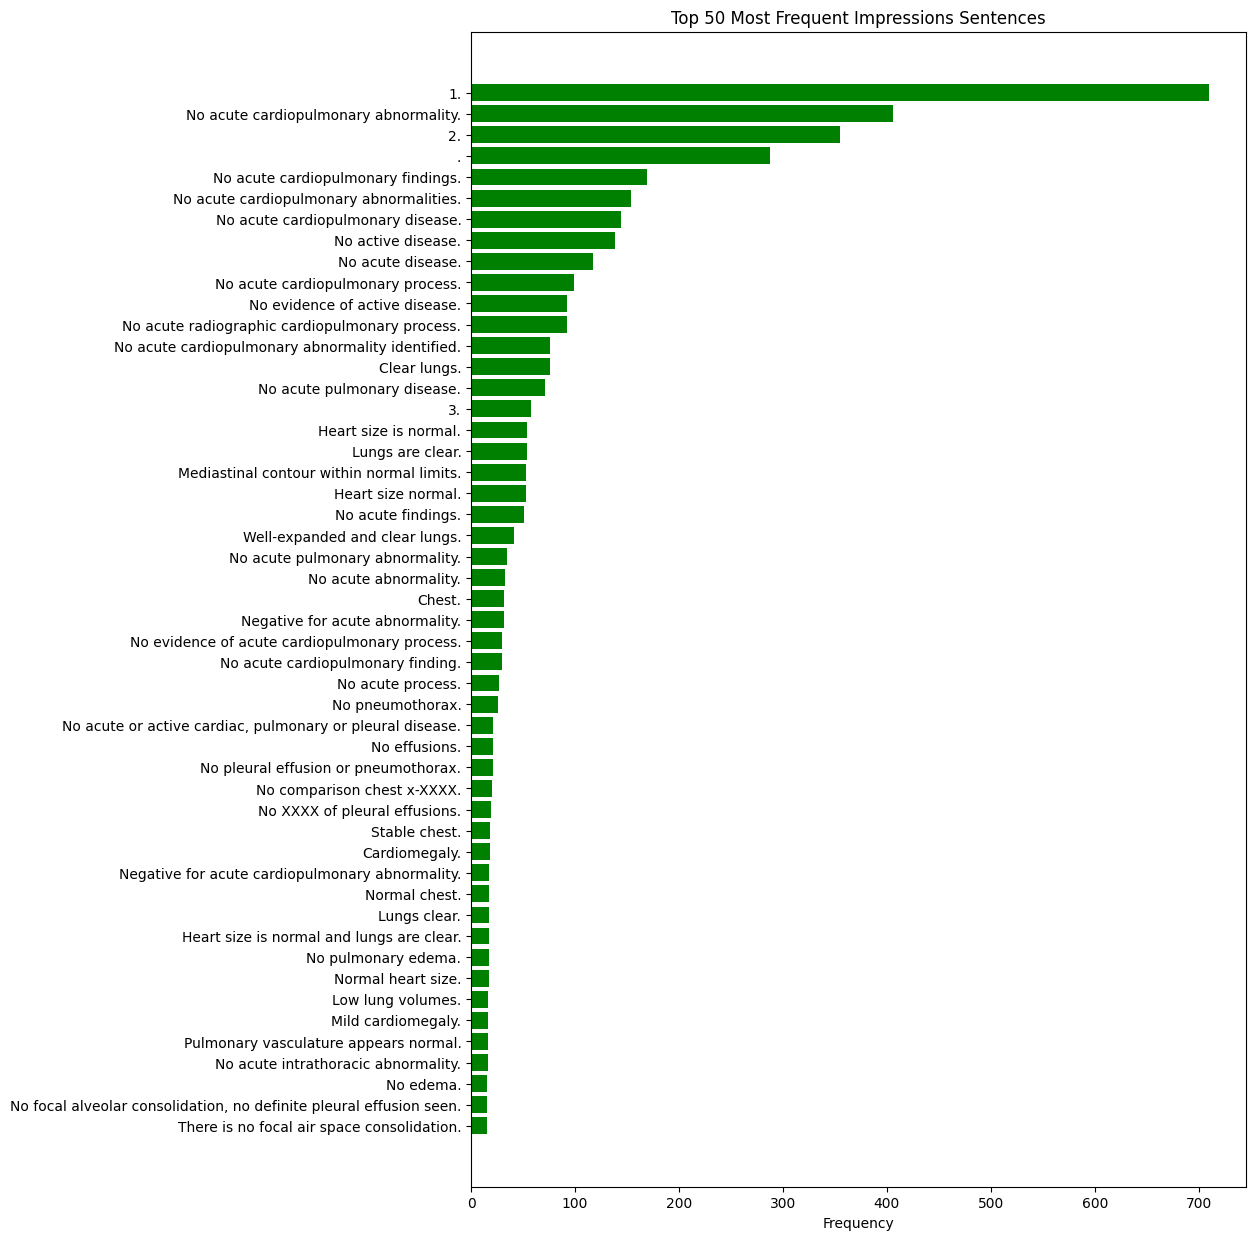

In [18]:
# Plot the top 50 sentences for impressions
impressions_sentences, impressions_frequencies = zip(*top_50_impressions)
plt.figure(figsize=(10, 15))
plt.barh(impressions_sentences, impressions_frequencies, color='green')
plt.xlabel('Frequency')
plt.title('Top 50 Most Frequent Impressions Sentences')
plt.gca().invert_yaxis()
plt.show()

# Unique Words vs Total Words

Total words in findings: 123347
Unique words in findings: 2136
Total words in impressions: 48830
Unique words in impressions: 2016


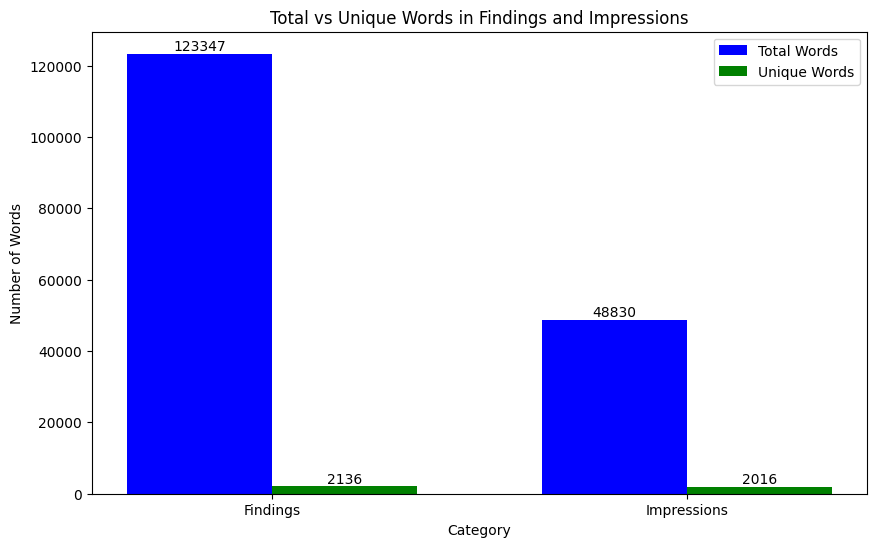

In [19]:
# Tokenize the findings and impressions into words
findings_words = nltk.word_tokenize(all_findings)
impressions_words = nltk.word_tokenize(all_impressions)

# Count the total and unique words in findings
total_words_findings = len(findings_words)
unique_words_findings = len(set(findings_words))

# Count the total and unique words in impressions
total_words_impressions = len(impressions_words)
unique_words_impressions = len(set(impressions_words))

# Print the results
print(f"Total words in findings: {total_words_findings}")
print(f"Unique words in findings: {unique_words_findings}")
print(f"Total words in impressions: {total_words_impressions}")
print(f"Unique words in impressions: {unique_words_impressions}")

# Create data for plotting
categories = ['Findings', 'Impressions']
total_words = [total_words_findings, total_words_impressions]
unique_words = [unique_words_findings, unique_words_impressions]

# Plot the results
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(categories))

bar1 = plt.bar(index, total_words, bar_width, label='Total Words', color='blue')
bar2 = plt.bar([i + bar_width for i in index], unique_words, bar_width, label='Unique Words', color='green')

plt.xlabel('Category')
plt.ylabel('Number of Words')
plt.title('Total vs Unique Words in Findings and Impressions')
plt.xticks([i + bar_width / 2 for i in index], categories)
plt.legend()

# Annotate the bars with counts
for bar in bar1:
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom')
for bar in bar2:
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom')

plt.show()

# Plotting PDF and CDF for Word Count distribution of Findings

In [20]:
reports_df['findings_count'] = reports_df['findings'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
reports_df['impression_count'] = reports_df['impression'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
reports_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression,findings_count,impression_count
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,34,3
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,14,4
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",1,23
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,64,47
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,42,4


In [21]:
#Printing min,max and median of word_count
print("Minimum number of word count for finding is:",np.min(reports_df.findings_count.values))
print("Maximum number of word count for finding is:",np.max(reports_df.findings_count.values))
print("Median number of word count for finding is:",np.median(reports_df.findings_count.values))

Minimum number of word count for finding is: 1
Maximum number of word count for finding is: 169
Median number of word count for finding is: 27.0


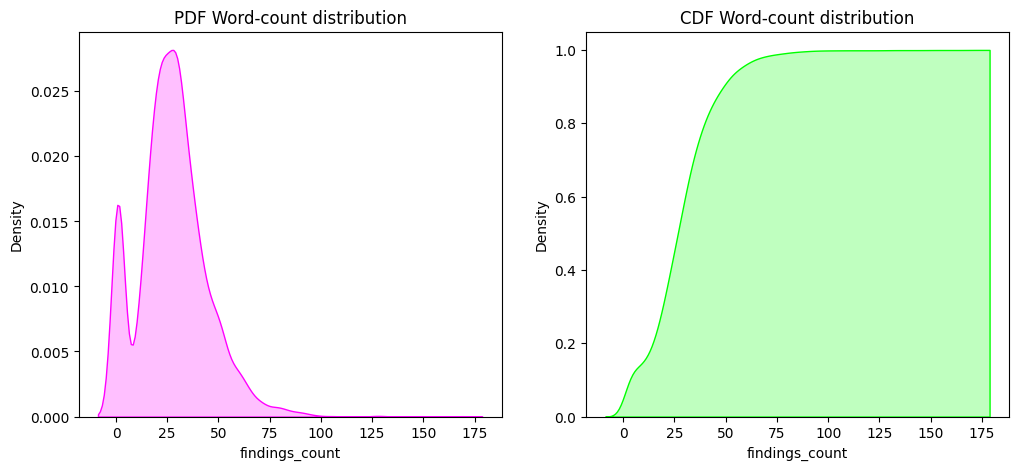

In [22]:
#Plotting the PDF for word_count distribution of Findings feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(reports_df['findings_count'],shade=True,color='Magenta')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(reports_df['findings_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

# Plotting PDF and CDF for Word Count distribution of Impressions

In [23]:
#Printing min,max and median of word_count
print("Minimum number of word count for finding is:",np.min(reports_df.impression_count.values))
print("Maximum number of word count for finding is:",np.max(reports_df.impression_count.values))
print("Median number of word count for finding is:",np.median(reports_df.impression_count.values))

Minimum number of word count for finding is: 1
Maximum number of word count for finding is: 130
Median number of word count for finding is: 5.0


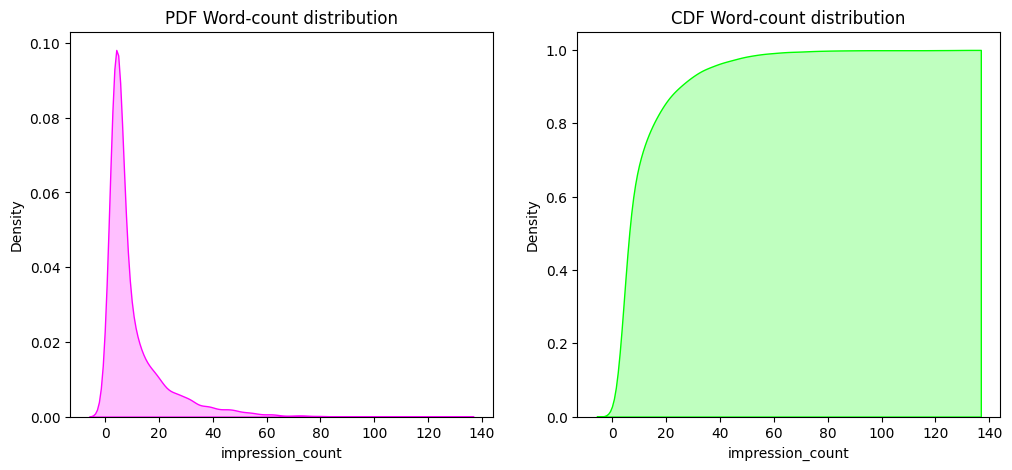

In [24]:
#Plotting the PDF for word_count distribution of Findings feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(reports_df['impression_count'],shade=True,color='Magenta')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(reports_df['impression_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

# Distribution of Findings and Impressions Length

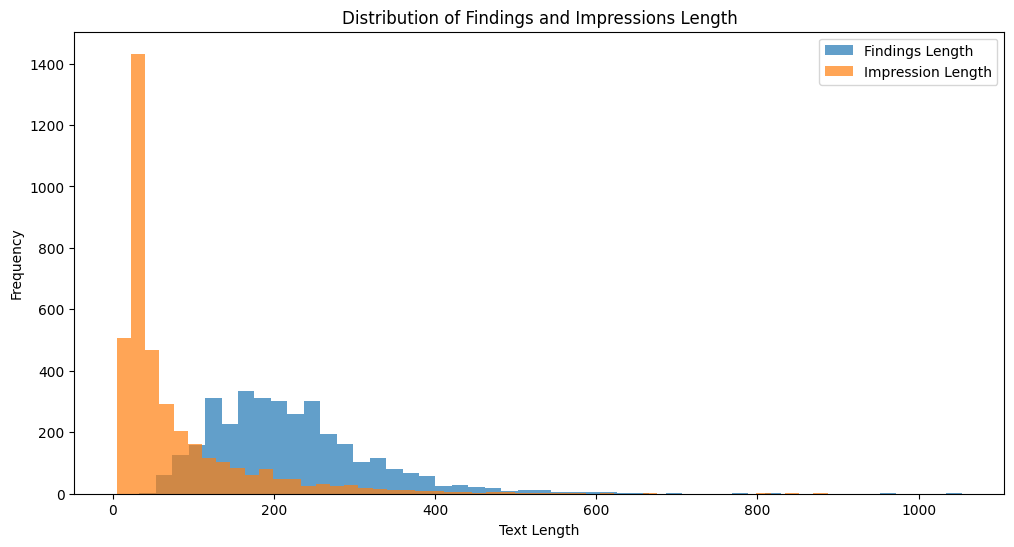

In [25]:
reports_df['findings_length'] = reports_df['findings'].dropna().apply(len)
reports_df['impression_length'] = reports_df['impression'].dropna().apply(len)

plt.figure(figsize=(12, 6))
plt.hist(reports_df['findings_length'], bins=50, alpha=0.7, label='Findings Length')
plt.hist(reports_df['impression_length'], bins=50, alpha=0.7, label='Impression Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Findings and Impressions Length')
plt.legend(loc='upper right')
plt.show()


# Top 10 Frequent Words in Findings and Impressions

In [26]:
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Make sure to download the stopwords dataset
nltk.download('stopwords')
nltk.download('punkt')

# Load your data
reports_df = pd.read_csv('/kaggle/input/cxr-dataset/reports.csv')

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum() and token not in stopwords.words('english')]
    return tokens

# Combine and preprocess text for findings and impressions
findings_text = " ".join(reports_df['findings'].dropna().values)
impressions_text = " ".join(reports_df['impression'].dropna().values)

findings_tokens = preprocess_text(findings_text)
impressions_tokens = preprocess_text(impressions_text)

# Get the most common words in findings and impressions
findings_counter = Counter(findings_tokens)
impressions_counter = Counter(impressions_tokens)

# Display the top 10 most common words in findings and impressions
top_10_findings = findings_counter.most_common(10)
top_10_impressions = impressions_counter.most_common(10)

print("Top 10 most common words in findings:")
for word, freq in top_10_findings:
    print(f"{word}: {freq}")

print("\nTop 10 most common words in impressions:")
for word, freq in top_10_impressions:
    print(f"{word}: {freq}")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Top 10 most common words in findings:
normal: 3445
pleural: 2438
pneumothorax: 2370
xxxx: 2351
effusion: 2144
heart: 2109
lungs: 1944
size: 1890
focal: 1717
within: 1499

Top 10 most common words in impressions:
acute: 2315
cardiopulmonary: 1620
disease: 1058
xxxx: 1055
abnormality: 766
right: 548
normal: 520
pulmonary: 487
left: 462
findings: 457


# Distribution of Image Dimensions and Aspect Ratios

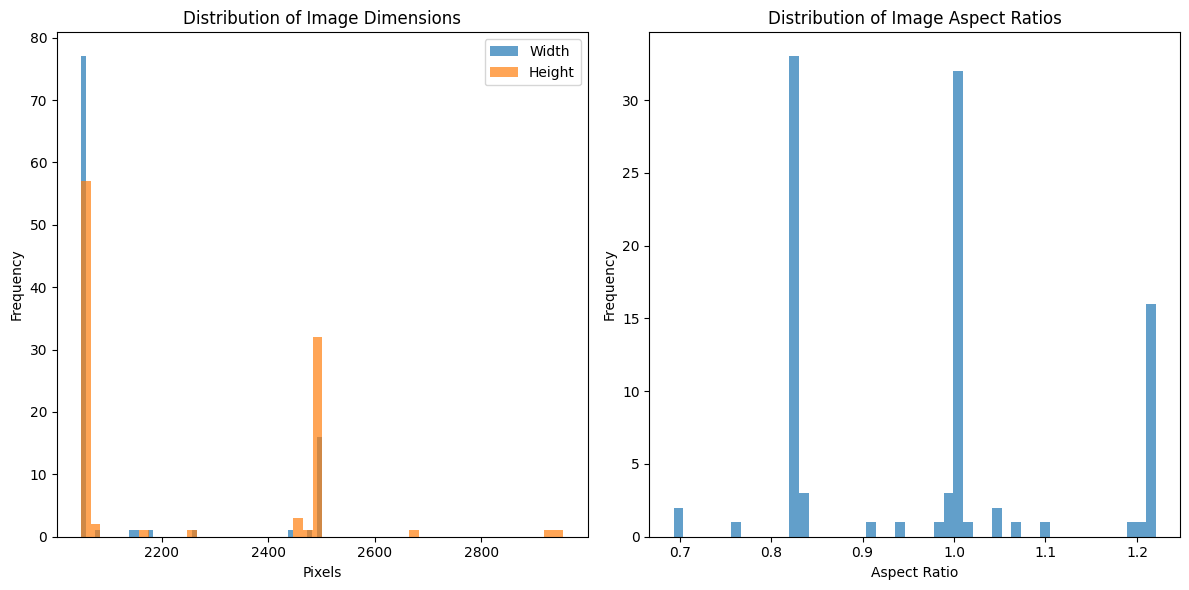

In [27]:
from PIL import Image
import os

image_sizes = []
aspect_ratios = []

for filename in projections_df['filename'].head(50):
    try:
        with Image.open(f'/kaggle/input/cxr-dataset/images/{filename}') as img:
            width, height = img.size
            image_sizes.append((width, height))
            aspect_ratios.append(width / height)
    except Exception as e:
        print(f"Error loading image {filename}: {e}")

# Convert to DataFrame for easier analysis
image_sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
aspect_ratios_series = pd.Series(aspect_ratios, name='Aspect Ratio')

# Plot the distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(image_sizes_df['Width'], bins=50, alpha=0.7, label='Width')
plt.hist(image_sizes_df['Height'], bins=50, alpha=0.7, label='Height')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Distribution of Image Dimensions')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(aspect_ratios_series, bins=50, alpha=0.7)
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Image Aspect Ratios')

plt.tight_layout()
plt.show()


# Distribution on Image Brightness & Contrast

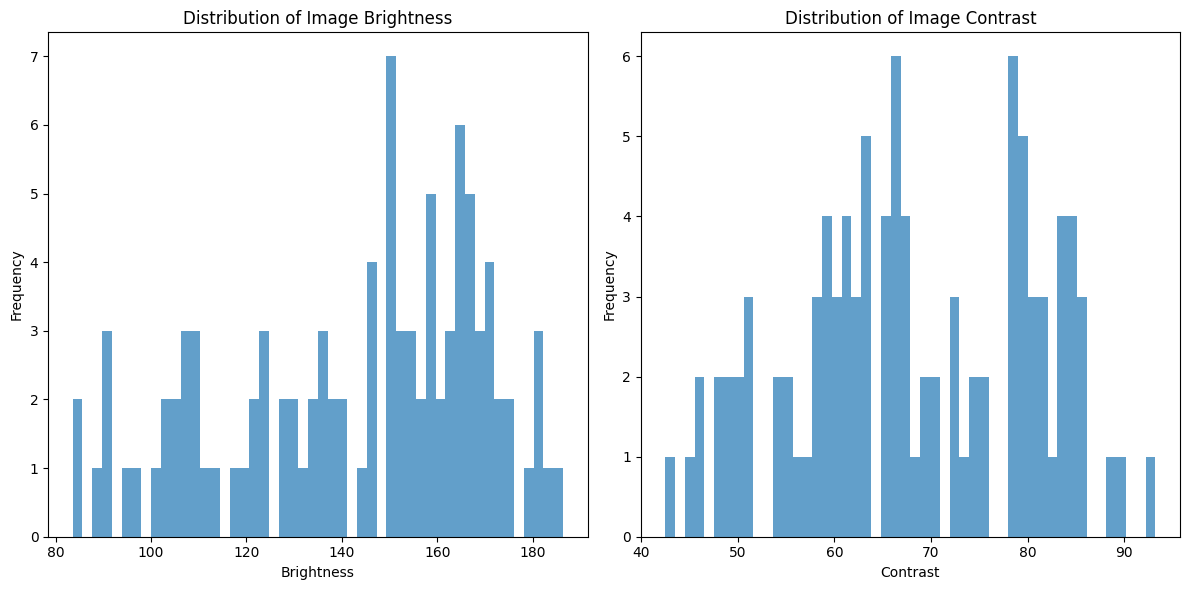

In [29]:
from PIL import ImageStat

brightness = []
contrast = []

for filename in projections_df['filename'].head(50):
    try:
        with Image.open(f'/kaggle/input/cxr-dataset/images/{filename}') as img:
            stat = ImageStat.Stat(img)
            brightness.append(stat.mean[0])  # Assuming grayscale images
            contrast.append(stat.stddev[0])
    except Exception as e:
        print(f"Error analyzing image {filename}: {e}")

# Convert to DataFrame for easier analysis
image_quality_df = pd.DataFrame({'Brightness': brightness, 'Contrast': contrast})

# Plot the distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(image_quality_df['Brightness'], bins=50, alpha=0.7)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Distribution of Image Brightness')

plt.subplot(1, 2, 2)
plt.hist(image_quality_df['Contrast'], bins=50, alpha=0.7)
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.title('Distribution of Image Contrast')

plt.tight_layout()
plt.show()


# Displaying a Report 

In [31]:
def display_sample(uid, images, projections, findings,impressions):
    plt.figure(figsize=(10, 5))
    print("UID:", uid)
    for i, (img, proj) in enumerate(zip(images, projections)):
        plt.subplot(1, len(images), i+1)
        png_img = Image.open(os.path.join(image_path, img))
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print("Findings:", findings)
    print("Impressions:",impressions)

In [ ]:
display_sample(uid, images, projections, findings,impressions)

# Splitting the dataset into train and test

In [33]:
uids = projections_df.uid.unique()
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

# Loading a Tokenizer to process the captions

In [34]:

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [35]:
findings_corpus = [tokenizer.encode(line)  for line in reports_df[reports_df.uid.isin(train_uids)].findings.dropna()]

In [36]:
impressions_corpus = [tokenizer.encode(line)  for line in reports_df[reports_df.uid.isin(train_uids)].impression.dropna()]

In [37]:
pd.Series([len(x) for x in findings_corpus]).describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

count    3003.000000
mean       51.048618
std        22.007258
min         8.000000
25%        37.000000
50%        48.000000
75%        61.000000
80%        67.000000
90%        80.000000
95%        92.000000
max       238.000000
dtype: float64

In [38]:
pd.Series([len(x) for x in impressions_corpus]).describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

count    3440.000000
mean       17.939244
std        19.098879
min         2.000000
25%         8.000000
50%        10.000000
75%        21.000000
80%        26.000000
90%        42.000000
95%        57.000000
max       205.000000
dtype: float64